In [1]:
import fitz
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd

In [44]:
pdf_address = "a.pdf"
doc = fitz.open(pdf_address)

page = doc.load_page(9)
page_dict = page.get_text("dict")
page_blocks = page_dict["blocks"]
page_blocks_2 = page.get_text("blocks")
page_text = page.get_text("text")

In [45]:
page_dict

{'width': 595.276,
 'height': 841.89,
 'blocks': [{'number': 0,
   'type': 0,
   'bbox': (68.03150177001953,
    805.250244140625,
    73.0354995727539,
    814.250244140625),
   'lines': [{'spans': [{'size': 9.0,
       'flags': 4,
       'font': 'FrutigerLTCom-Roman',
       'color': 0,
       'ascender': 0.75,
       'descender': -0.25,
       'text': '8',
       'origin': (68.03150177001953, 812.000244140625),
       'bbox': (68.03150177001953,
        805.250244140625,
        73.0354995727539,
        814.250244140625)}],
     'wmode': 0,
     'dir': (1.0, 0.0),
     'bbox': (68.03150177001953,
      805.250244140625,
      73.0354995727539,
      814.250244140625)}]},
  {'number': 1,
   'type': 0,
   'bbox': (68.03150177001953,
    34.0159912109375,
    204.282470703125,
    43.0159912109375),
   'lines': [{'spans': [{'size': 9.0,
       'flags': 4,
       'font': 'FrutigerLTCom-Light',
       'color': 0,
       'ascender': 0.75,
       'descender': -0.25,
       'text': 'M A S 

In [46]:
def find_blocks_clusters(page, do_plot=False):

    def get_center(bbox, x_tol=1, y_tol=1, x_y_scale=1):
        x0, y0, x1, y1 = bbox
        x0 = (round(x0 / x_tol)) * round(x_tol) * x_y_scale
        x1 = (round(x1 / x_tol)) * round(x_tol) * x_y_scale
        y0 = (round(y0 / y_tol)) * round(y_tol)
        y1 = (round(y1 / y_tol)) * round(y_tol)
        return ((x0 + x1) / 2, (y0 + y1) / 2)

    page_dict = page.get_text("dict")
    page_blocks = page_dict["blocks"]

    x_tol = page_dict['width']/20

    if page_blocks:
        center_points = [get_center(block['bbox'], x_tol=x_tol) for block in page_blocks]
        scaled_points = [(x, y) for x, y in [get_center(block['bbox'], x_tol=x_tol, x_y_scale=0.5) for block in page_blocks]]

        clustering = DBSCAN(eps=x_tol+5, min_samples=1).fit(scaled_points)
        labels = clustering.labels_

        for i, block in enumerate(page_blocks):
            block['cluster'] = labels[i]

        if do_plot:

            test = []
            test1 = scaled_points
            for i, block in enumerate(page_blocks):
                block['cluster'] = labels[i]
                test2 = [test1[i][0], test1[i][1], labels[i]]
                test.append(test2)

            x_coords = [point[0] for point in test]
            y_coords = [point[1] for point in test]
            colors = [point[2] for point in test]

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.scatter(x_coords, y_coords, c=colors)
            ax1.set_xlabel('X Coordinate')
            ax1.set_ylabel('Y Coordinate')
            ax1.set_title('Points with Color Coding')
            ax1.axis('scaled')
            ax1.set_xlim(0, page_dict['width'])
            ax1.set_ylim(0, page_dict['height'])
            ax1.invert_yaxis()

            center_x_coords = [point[0] for point in center_points]
            center_y_coords = [point[1] for point in center_points]

            ax2.scatter(center_x_coords, center_y_coords, c=colors)
            ax2.set_xlabel('X Coordinate')
            ax2.set_ylabel('Y Coordinate')
            ax2.set_title('Center Points')
            ax2.axis('scaled')
            ax2.set_xlim(0, page_dict['width'])
            ax2.set_ylim(0, page_dict['height'])
            ax2.invert_yaxis()

            plt.subplots_adjust(wspace=0.4)
            plt.show()

    return page_blocks

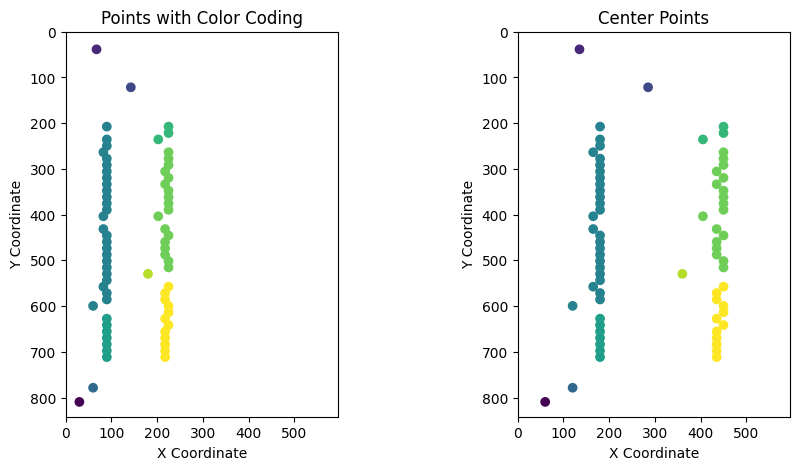

[{'number': 0,
  'type': 0,
  'bbox': (68.03150177001953,
   805.250244140625,
   73.0354995727539,
   814.250244140625),
  'lines': [{'spans': [{'size': 9.0,
      'flags': 4,
      'font': 'FrutigerLTCom-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '8',
      'origin': (68.03150177001953, 812.000244140625),
      'bbox': (68.03150177001953,
       805.250244140625,
       73.0354995727539,
       814.250244140625)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (68.03150177001953,
     805.250244140625,
     73.0354995727539,
     814.250244140625)}],
  'cluster': 0},
 {'number': 1,
  'type': 0,
  'bbox': (68.03150177001953,
   34.0159912109375,
   204.282470703125,
   43.0159912109375),
  'lines': [{'spans': [{'size': 9.0,
      'flags': 4,
      'font': 'FrutigerLTCom-Light',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': 'M A S C H I N E L L E S  L E R N E N',
      'origin': (68.03150177001953, 

In [33]:
find_blocks_clusters(page, do_plot=True)

In [34]:
def sort_block_cluster_coordinate(blocks):
    divided_blocks = []
    for block in blocks:
        cluster = block['cluster']
        if len(divided_blocks) <= cluster:
            divided_blocks.append([cluster])
        divided_blocks[cluster].append(block)

    divided_blocks.sort(key=lambda x: x[0])
    #divided_blocks = [item[1] for item in divided_blocks]
    for item in divided_blocks:
        item.pop(0)
    #print(divided_blocks)
    
    for item in divided_blocks:
        item.sort(key=lambda x: (x['bbox'][0], x['bbox'][1]))

    #divided_blocks.sort(key=lambda x: (x[0]['bbox'][0], x[0]['bbox'][1]))

    sorted_blocks = []
    for i in divided_blocks:
        for j in i:
            sorted_blocks.append(j)
        
    return sorted_blocks

In [35]:
def find_titles(sorted_lines_blocks):
    blocks = sorted_lines_blocks
    if blocks: #if not blocks is None:
        page_font_sizes = []
        page_font_names = []
        for b in blocks:  # iterate through the text blocks
            for l in b.get("lines", []):  # iterate through the text lines
                for s in l.get("spans",[]):  # iterate through the text spans
                    #print("")
                    page_font_sizes.append(s["size"])
                    page_font_names.append(s["font"])
                    
        page_font_sizes_counter = Counter(page_font_sizes)
        most_common_font_size, most_common_count = page_font_sizes_counter.most_common(1)[0]

        if most_common_count / len(page_font_sizes) > 0.5:
            title_font_sizes = [x for x in page_font_sizes if x > most_common_font_size]
        else:
            return None
        
        title_blocks = []
        for b in blocks:  # iterate through the text blocks
            for l in b.get("lines", []):  # iterate through the text lines
                for s in l.get("spans",[]):  # iterate through the text spans
                    if s["size"] in title_font_sizes:
                        title_blocks.append(b)

        return title_blocks
    
    else:
        return None

In [36]:
def is_title(page_block, page_titles):
    if page_block is None:
        return False
    if not page_titles:
        return False
    for item in page_titles:
        if item['bbox'] == page_block['bbox'][:4]:
            return True
    return False

In [37]:
def extract_image_from_page(pdf_document, page, page_number):
    image_list = page.get_images(full=True)
    if image_list is None:
        return None
    else:
        images_name = []
        info_names = []   #write decription about info of images in PyMuPDF.
        images_y0 = []
        for img_index, img_info in enumerate(image_list):
            xref = img_info[0]
            image_info_name = img_info[7]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image_filename = f"image_{page_number+1}_{img_index + 1}.png"
            y0 = page.get_image_bbox(img_info)[1]  
            images_name.append(image_filename)
            info_names.append(image_info_name)
            images_y0.append(y0)
            with open(image_filename, "wb") as image_file:
                image_file.write(image_bytes)
        return images_name, info_names, images_y0

In [39]:
pdf_address = "a.pdf"
doc = fitz.open(pdf_address)
page = doc.load_page(10)
page_dict = page.get_text("dict")
page_blocks = page_dict["blocks"]

In [40]:
def make_master_list(pdf_doc):
    master_list = []

    for page_num in range(len(pdf_doc)):
        page = pdf_doc.load_page(page_num)
        page_blocks_with_clusters = find_blocks_clusters(page)
        sorted_page_blocks = sort_block_cluster_coordinate(page_blocks_with_clusters)
        page_titles = find_titles(sorted_page_blocks)
        image_names, image_info_names, images_y0 = extract_image_from_page(pdf_doc, page, page_num)

        image_counter = 0  # Initialize outside the loop

        for block in sorted_page_blocks:
            text = ""
            image = []

            if block.get("lines"):
                for line in block["lines"]:
                    if line.get("spans"):
                        for span in line["spans"]:
                            if "text" in span:
                                text += span["text"] + " "  # Append text from each span

            elif block.get("image") and image_counter < len(image_names):
                image = image_names[image_counter]
                image_counter += 1

            block_dict = {
                "page": page_num,
                "bbox": block['bbox'][0:4],  # Position of the text block
                "text": text.strip(),   # Text content of the block
                "image": image,
                "title": is_title(block, page_titles)
            }
            master_list.append(block_dict)

    return master_list


In [41]:
doc_list = make_master_list(doc)
parts_list = []
part_text = []
part_images = []  # List to accumulate images

index = 0
start_page = 0
title = None
while index < len(doc_list):
    item = doc_list[index]
    next_item = doc_list[index + 1] if index + 1 < len(doc_list) else None

    # Check and accumulate images
    if item["image"]:
        if isinstance(item["image"], list):  # If it's a list, extend
            part_images.extend(item["image"])
        elif isinstance(item["image"], str):  # If it's a string, append
            part_images.append(item["image"])

    if item['title'] == True:
        title = item["text"]
        start_page = item["page"]
        if next_item and next_item["title"]:
            end_page = next_item["page"]
            part_dict = {
                'title': title,
                'pages': f'{start_page + 1}-{end_page + 1}',
                'text': part_text,
                'images': part_images  # Use accumulated images
            }
            parts_list.append(part_dict)
            part_text = []
            part_images = []  # Reset for next group
    else:
        part_text.append(item["text"])
        if next_item and next_item['title'] == True:
            end_page = next_item["page"]
            part_dict = {
                'title': title,
                'pages': f'{start_page + 1}-{end_page + 1}',
                'text': part_text,
                'images': part_images  # Use accumulated images
            }
            parts_list.append(part_dict)
            part_text = []
            part_images = []  # Reset for next group

    index += 1


In [42]:
parts_list

[{'title': None,
  'pages': '1-3',
  'text': ['',
   'MASCHINELLES LERNEN',
   'EINE ANALYSE ZU KOMPETENZEN, FORSCHUNG UND ANWENDUNG',
   ''],
  'images': []},
 {'title': 'MASCHINELLES LERNEN', 'pages': '3-3', 'text': [], 'images': []},
 {'title': 'EINE ANALYSE ZU KOMPETENZEN,   FORSCHUNG UND ANWENDUNG',
  'pages': '3-4',
  'text': ['F R A U N H O F E R - G E S E L L S C H A F T',
   'Autoren',
   'Inga Döbel | Fraunhofer IMW',
   'Dr. Miriam Leis | Fraunhofer-Zentrale',
   'Manuel Molina Vogelsang | Fraunhofer IMW',
   'Dmitry Neustroev | Fraunhofer IMW',
   'Dr. Henning Petzka | Fraunhofer IAIS',
   'Annamaria Riemer | Fraunhofer IMW',
   'Dr. Stefan Rüping | Fraunhofer IAIS',
   'Dr. Angelika Voss | Fraunhofer IAIS',
   'Martin Wegele | Fraunhofer-Zentrale',
   'Dr. Juliane Welz | Fraunhofer IMW',
   'in Kooperation mit',
   'Forschungszentrum Maschinelles Lernen im Fraunhofer-',
   'Cluster of Excellence Cognitive Internet Technologies',
   'Fraunhofer-Allianz Big Data & Künstliche

In [50]:
print("\n".join(parts_list[6]['text']))

1  De Spiegeleire/Maas/Sweijs 2017 2  Bitkom 2017
derartigen manuellen Wissenseingaben oder gar der expliziten
Programmierung eines Lösungswegs ist man bei komplexeren
Aufgaben der KI jedoch gescheitert. Eine Alternative hierzu
bietet das Maschinelle Lernen, das heute tatsächlich die
Schlüsseltech nologie intelligenter Systeme darstellt.
Maschinelles Lernen bezweckt die Generierung von
»Wissen« aus »Erfahrung«, indem Lernalgorithmen aus Bei-
spielen ein komplexes Modell entwickeln. Das Modell, und
damit die automatisch erworbene Wissensrepräsentation,
kann anschließend auf neue, potenziell unbekannte Daten
derselben Art angewendet werden. Immer wenn Prozesse
zu kompliziert sind, um sie analytisch zu beschreiben, aber
genügend viele Beispieldaten – etwa Sensordaten, Bilder
oder Texte – verfügbar sind, bietet sich Maschinelles Lernen
an. Mit den gelernten Modellen können Vorhersagen
getroffen oder Empfehlungen und Entscheidungen generiert
werden – ganz ohne im Vor hinein festgelegte Rege

In [43]:
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 10000)
pd.DataFrame(parts_list)

title  \
0                                                                                                       None   
1                                                                                        MASCHINELLES LERNEN   
2                                                     EINE ANALYSE ZU KOMPETENZEN,   FORSCHUNG UND ANWENDUNG   
3                                                                                                     INHALT   
4                                                                                                    VORWORT   
5                                                                                          EXECUTIVE SUMMARY   
6                                              1   KONZEPTE, METHODEN UND GRENZEN   DES MASCHINELLEN LERNENS   
7                                                                                                          9   
8    K O N Z E P T E ,  M E T H O D E N  U N D  G R E N Z E N  D E S  M A S C H I N E L L E N  L E R N E N S   
9                                                                     1.2  Ein kurzer historischer Überblick   
10                                                  Maschinelles Lernen kann auf eine recht lange Geschichte   
11                                                   zurückblicken und ist aus Methoden der Statistik und KI   
12                                                 hervorgegangen. Angeregt durch das Verständnis verteilter   
13                                                   neuronaler Prozesse im Gehirn entstanden bereits in den   
14                                                       späten 1940er Jahren erste Konzepte von Künstlichen   
15                                                      Neuronalen Netzen (KNN) und fanden zehn Jahre später   
16                                                 erste Implementierungen. Ende der 1960er Jahre haben zwei   
17                                             bekannte KI-Wissenschaftler, Minsky und Papert, gezeigt, dass   
18                                                 damals ein einziges Neuron schon die elementare Entweder-   
19                                                oder-Logik nicht lernen konnte und größere Neuronale Netze   
20                                              mit wenigen lokalen Vernetzungen in ihrer Ausdrucksfähigkeit   
21                                               beschränkt waren. Dies führte in den 1970er Jahren zur Sta-   
22                                                gnation der KI-Forschung, insbesondere an KNN, und leitete   
23                                                                   den sogenannten ersten »KI-Winter« ein.   
24                                                 In den 1980er Jahren konzentrierte sich die Forschung auf   
25                                                symbolische Expertensysteme. Ihre Wissensbasis bestand aus   
26                                               manuell eingegebenen logischen Regeln, die sich auf manuell   
27                                                  selektierte Merkmale oder ebenfalls manuell konstruierte   
28                                                 Objekthierarchien bezogen. Solche Wissensrepräsentationen   
29                                            bezeichnet man als »symbolisches Wissen«. Es stellte sich aber   
30                                                heraus, dass ein konsistenter Ausbau größerer Wissensbasen   
31                                                                        2  AKTEURE UND KOMPETENZLANDSCHAFT   
32                                                                                                        15   
33                                               A K T E U R E  U N D  K O M P E T E N Z L A N D S C H A F T   
34                                                 Die zehn publikationsstärksten Organisationen stammen aus   
35                                                  der Wissenschaft, w